In [2]:
#!pip install ShopifyAPI

## Acquiring Data From Shopify API

This Notebook contains all the code I used to get all the data for Analysis of BoxFox's customers and orders. 

In [3]:
import shopify
import requests
import re
import json
import pandas as pd
from pandas.io.json import json_normalize
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from ConfigParser import SafeConfigParser

%matplotlib inline

In [10]:
parser = SafeConfigParser()
parser.read('config.ini')


API_KEY = parser.get('API_config', 'api_key')
PASSWORD = parser.get('API_config', 'api_password')
shop_url = "https://%s:%s@boxfox.myshopify.com/admin/" % (API_KEY, PASSWORD)
shopify.ShopifyResource.set_site(shop_url)

### Create Products Table

In [7]:
#functions to return list of ids for each page in API response

def get_product_ids(page):
    product_ids = []
    for p in shopify.Product.find(page=page):
        product_ids.append(p.get_id())
    return product_ids

def get_customer_ids(page):
    customer_ids = []
    for c in shopify.Customer.find(page=page):
        customer_ids.append(c.get_id())
    return customer_ids

def get_order_ids(page):
    order_ids = []
    for o in shopify.Order.find(page=page):
        order_ids.append(o.get_id())
    return order_ids

In [12]:

###Shopify API Pagination at 50 per request
pages = shopify.Product.count() // 50

# lists contain values of DataFrame

prod_id = []
desc = []
title = []
date_created = []
vendor = []
price = []
prod_type = []
inv_qty = []
old_inv_qty = []
fulfillment = []


for page in range(87, pages + 1):
    product_ids = get_product_ids(page)
    for id_ in product_ids:
        time.sleep(1)
        prod = shopify.Product.get(id_)
        prod_id.append(id_)
        desc.append(prod['body_html'])
        vendor.append(prod['vendor'])
        price.append(prod['variants'][0]['price'])
        inv_qty.append(prod['variants'][0]['inventory_quantity'])
        old_inv_qty.append(prod['variants'][0]['old_inventory_quantity'])
        fulfillment.append(prod['variants'][0]['fulfillment_service'])
        date_created.append(prod['created_at'])
        title.append(prod['title'])
        prod_type.append(prod['product_type'])

In [40]:
products = pd.DataFrame({'prod_id': prod_id,
             'desc': desc,
             'title': title,
             'date_created': date_created,
             'vendor': vendor,
             'price': price,
             'prod_type': prod_type,
             'inv_qty': inv_qty,
             'old_inv_qty': old_inv_qty,
             'fulfillment': fulfillment}
            )

products.head(3)
products.to_csv('products.csv', encoding = 'utf-8')

### Create Customers Table

In [14]:
pages = shopify.Customer.count() // 50

# cust_id = []
# accepts_marketing = []
# user_since = []
# zip_code = []
# state = []
# total_orders = []
# total_spent = []
# state = []

for page in range(87, pages + 1):
    customer_ids = get_customer_ids(page)
    for id_ in customer_ids:
        cust = cust_id.append(id_)
        time.sleep(.5)
        cust = shopify.Customer.get(id_)
        accepts_marketing.append(cust['accepts_marketing'])
        user_since.append(cust['created_at'])
        total_orders.append(cust['orders_count'])
        total_spent.append(cust['total_spent'])
        if 'default_address' in cust.keys():
            address = cust['default_address']
            zip_code.append(address['zip'])
            state.append(address['province_code'])
        else:
            zip_code.append(np.nan)
            state.append(np.nan)

In [13]:
customers = pd.DataFrame({'cust_id': cust_id,
                        'accepts_marketing': accepts_marketing,
                        'user_since': user_since,
                         'zip': zip_code,
                         'state': state,
                         'total_orders': total_orders,
                         'total_spent': total_spent}
                        )

customers.head(3)

In [74]:
customers.to_csv('customers.csv', encoding = 'utf-8')

9650

### Create Orders

In [125]:
pages = shopify.Order.count() // 50

for page in range(1, pages + 1):
    order_ids = get_order_ids(page)
    for id_ in order_ids:
        time.sleep(.5)
        order = shopify.Order.get(id_)
        order_df = json_normalize(order)
        orders = pd.concat([orders, order_df])

In [126]:
orders.head()

,billing_address.address1,billing_address.address2,billing_address.city,billing_address.company,billing_address.country,billing_address.country_code,billing_address.first_name,billing_address.last_name,billing_address.latitude,billing_address.longitude,...,test,token,total_discounts,total_line_items_price,total_price,total_price_usd,total_tax,total_weight,updated_at,user_id
0,620 Magnolia Ave.,,Pasadena,Chateau de Pilmer,United States,US,Susie,Pilmer,34.1352,-118.144,...,False,af8a143ff88c77a90a58b447d4f62429,0.00,89.50,117.93,117.93,7.83,2268,2017-03-21T11:20:07-07:00,None
0,2580 Armacost Ave,,Los Angeles,,United States,US,Gina,Binder,34.0257,-118.446,...,False,00bd07f118aa4dc8b26544e1e88fe6de,0.00,70.00,96.73,96.73,6.13,2268,2017-03-21T11:17:44-07:00,None
0,15905 28th Drive SE,,Mill Creek,,United States,US,Ashley,Walton,47.8538,-122.194,...,False,1400bc73f57db029b0d4f95e789de7f7,0.00,65.00,76.00,76.00,0.00,2268,2017-03-21T10:22:49-07:00,None
0,"702 harrison st, suite a",,berkeley,,United States,US,rhiannon,smith,37.8803,-122.305,...,False,2c76bb7f669eed92af8c37e9831236a4,0.00,56.00,71.06,71.06,4.06,2268,2017-03-21T10:10:26-07:00,None
0,4 Smoky Lane,,Westport,,United States,US,Samantha,Smolka,41.1298,-73.3439,...,False,cbb50d0d631a8225f366e62296483613,0.00,65.50,76.50,76.50,0.00,2268,2017-03-21T09:18:44-07:00,None


In [128]:
orders.to_csv('orders.csv', encoding= 'utf-8')

In [129]:
for c in orders.columns:
    print(c)

billing_address.address1
billing_address.address2
billing_address.city
billing_address.company
billing_address.country
billing_address.country_code
billing_address.first_name
billing_address.last_name
billing_address.latitude
billing_address.longitude
billing_address.name
billing_address.phone
billing_address.province
billing_address.province_code
billing_address.zip
browser_ip
buyer_accepts_marketing
cancel_reason
cancelled_at
cart_token
checkout_id
checkout_token
client_details.accept_language
client_details.browser_height
client_details.browser_ip
client_details.browser_width
client_details.session_hash
client_details.user_agent
closed_at
confirmed
contact_email
created_at
currency
customer.accepts_marketing
customer.created_at
customer.default_address.address1
customer.default_address.address2
customer.default_address.city
customer.default_address.company
customer.default_address.country
customer.default_address.country_code
customer.default_address.country_name
customer.default_ad

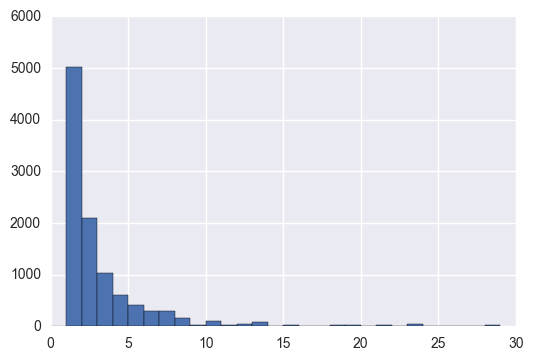

In [173]:
plt.hist(orders.fillna(0)['customer.orders_count'].astype('int'), bins=29);